In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import os
import re

# Leer datos Indices de Rezago Social

In [2]:
folders_IRS = os.listdir("data/")
folders_IRS = ["data/"+i for i in folders_IRS if "IRS" in i]
folders_IRS

['data/IRS_localidades_2000.xlsx',
 'data/IRS_localidades_2005.xlsx',
 'data/IRS_localidades_2010.xlsx',
 'data/IRS_localidades_2020.xlsx']

In [3]:
rename_columns = {
    "Indicadores de rezago social (porcentaje)":np.NaN,
    "Entidad \nfederativa":"Entidad federativa",
    "Población \ntotal":"Población total",
}

In [11]:
def loadISR(folders_IRS):
    ISR_full = pd.DataFrame()
    colnames = []

    for folder in folders_IRS:
        ISR_df = pd.ExcelFile(folder)
        year = folder[:-5].split("_")[-1]
        for sheet in ISR_df.sheet_names:
            ISR_sheet = ISR_df.parse(sheet, skiprows=4)
            ISR_sheet.replace(rename_columns, inplace=True)
            ISR_sheet[:2] = ISR_sheet[:2].fillna(method="bfill")

            ISR_sheet.columns = ISR_sheet.iloc[0]
            ISR_sheet.drop(ISR_sheet.index[0], inplace=True)
            ISR_sheet.dropna(subset="Localidad", inplace=True)
            ISR_sheet.dropna(how="all", axis=1, inplace=True)
            ISR_sheet["year"] = year

            ISR_full = pd.concat([ISR_full, ISR_sheet], ignore_index=True)
            colnames.append(ISR_sheet.columns)

    return ISR_full
#ISR_full = loadISR(folders_IRS)
#ISR_full.to_csv("data/ISR_full.csv",index=False)
ISR_full = pd.read_csv("data/ISR_full.csv")
ISR_full["Entidad federativa"] = [i.lower().title() for i in ISR_full["Entidad federativa"]]

ISR_full["Entidad federativa"].replace({
    "Varacruz De Ignacio De La Llave":"Veracruz De Ignacio De La Llave",
    "Distrito Federal":"Ciudad De México",
    "Querétaro":"Querétaro De Arteaga"}, inplace=True)
ISR_full

,Clave localidad,Entidad federativa,Municipio,Localidad,Población total,Población de 15 años o más analfabeta,Población de 6 a 14 años que no asiste a la escuela,Población de 15 años y más con educación básica incompleta,Población sin derechohabiencia a servicios de salud,Viviendas con piso de tierra,...,Viviendas que no disponen de drenaje,Viviendas que no disponen de energía eléctrica,Viviendas que no disponen de lavadora,Viviendas que no disponen de refrigerador,Índice de rezago social,Grado de rezago social,Lugar que ocupa en el contexto nacional,year,"Hogares con población de 15 a 29 años, con algún habitante con menos de 9 años de educación aprobados",Promedio de ocupantes por cuarto
0,10010001,Aguascalientes,AGUASCALIENTES,AGUASCALIENTES,594092,3.407850,5.145010,40.869800,34.093040,1.909650,...,0.979540,0.762040,17.940530,10.573430,-2.447551,Muy bajo,106455.0,2000,NaN,NaN
1,10010096,Aguascalientes,AGUASCALIENTES,AGUA AZUL,79,20.833330,5.882350,85.416670,53.164560,6.666670,...,73.333330,13.333330,53.333340,33.333330,-0.599735,Bajo,77208.0,2000,NaN,NaN
2,10010106,Aguascalientes,AGUASCALIENTES,ARELLANO,1059,8.681130,11.153850,69.282140,47.780930,7.462690,...,5.472640,2.985070,41.293530,27.363180,-1.752400,Muy bajo,102049.0,2000,NaN,NaN
3,10010112,Aguascalientes,AGUASCALIENTES,BAJIO LOS VAZQUEZ,69,12.000000,0.000000,82.000000,89.855070,0.000000,...,50.000000,0.000000,33.333330,25.000000,-1.364606,Bajo,95650.0,2000,NaN,NaN
4,10010120,Aguascalientes,AGUASCALIENTES,BUENAVISTA DE PEÑUELAS,588,16.164380,6.569340,72.602740,27.551020,0.862070,...,13.793100,0.000000,35.344830,16.379310,-1.861600,Muy bajo,103293.0,2000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423462,320580030,Zacatecas,Santa María de la Paz,Las Tablas,34,12.000000,0.000000,56.000000,0.000000,7.692308,...,38.461538,0.000000,30.769231,23.076923,-0.375147,Bajo,59280.0,2020,NaN,NaN
423463,320580033,Zacatecas,Santa María de la Paz,Los Horcones,12,16.666667,0.000000,100.000000,16.666667,28.571429,...,57.142857,0.000000,28.571429,28.571429,0.192058,Medio,34484.0,2020,NaN,NaN
423464,320580035,Zacatecas,Santa María de la Paz,Los Trigos (Mesa de los Trigos),89,4.411765,0.000000,55.882353,15.730337,4.347826,...,13.043478,4.347826,21.739130,8.695652,-0.628247,Bajo,75373.0,2020,NaN,NaN
423465,320580037,Zacatecas,Santa María de la Paz,Mesa Grande,165,2.400000,3.571429,60.000000,10.303030,8.163265,...,20.408163,0.000000,12.244898,0.000000,-0.806189,Bajo,87671.0,2020,NaN,NaN


# Datos DAYMET

In [2]:
daymet_root = "data/daymet/"
list_daymet = os.listdir(daymet_root)
list_daymet = [daymet_root+i for i in list_daymet]
print(len(list_daymet))
list_daymet[:5]

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'data/daymet/'

In [7]:
code_ent = {
    1: "AGUASCALIENTES",
    2: "BAJA CALIFORNIA",
    3: "BAJA CALIFORNIA SUR",
    4: "CAMPECHE",
    5: "COAHUILA DE ZARAGOZA",
    6: "COLIMA",
    7: "CHIAPAS",
    8: "CHIHUAHUA",
    9: "DISTRITO FEDERAL",
    10: "DURANGO",
    11: "GUANAJUATO",
    12: "GUERRERO",
    13: "HIDALGO",
    14: "JALISCO",
    15: "MEXICO",
    16: "MICHOACAN DE OCAMPO",
    17: "MORELOS",
    18: "NAYARIT",
    19: "NUEVO LEON",
    20: "OAXACA",
    21: "PUEBLA",
    22: "QUERETARO DE ARTEAGA",
    23: "QUINTANA ROO",
    24: "SAN LUIS POTOSI",
    25: "SINALOA",
    26: "SONORA",
    27: "TABASCO",
    28: "TAMAULIPAS",
    29: "TLAXCALA",
    30: "VERACRUZ DE IGNACIO DE LA LLAVE",
    31: "YUCATAN",
    32: "ZACATECAS"}

In [30]:
def read_daymet(dirs):
    df_final = pd.DataFrame(columns=[
        "dayl","prcp","srad","swe","tmax","tmin","vp", 'CVE_ENT', 'date'
    ])
    for dir in dirs:
        df = pd.read_csv(dir)
        date = dir[12:-4]
        df["date"] = date

        df.drop(columns=["NOMGEO","CVE_MUN","CVE_LOC","AMBITO","CVEGEO","system:index"],
                inplace=True)

        df_final["CVE_ENT"].replace(code_ent, inplace=True)
        print(df_final.columns, date)
        df_final = pd.concat([df_final, df])
        df_final.to_csv(f"data/daymet_parcial.csv",index=False)

    df_final["date"] = pd.to_datetime(df_final["date"],
                                      infer_datetime_format=True)
    df_final["week_index"] = df_final.date.dt.week
    df_final["year"] = df_final.date.dt.year

    df_final.rename(columns={"CVE_ENT":"estado"}, inplace=True)

    return df_final

#df_daymet = read_daymet(list_daymet)
#df_daymet.to_csv("data/daymet_full.csv",index=False)
df_daymet = pd.read_csv("data/daymet_full.csv")
#df_daymet.drop(columns="date",inplace=True)
df_daymet.head()

,dayl,prcp,srad,swe,tmax,tmin,vp,estado,date,week_index,year
0,39689.867188,0.0,423.457507,0.0,22.787601,4.867051,864.393971,1,2001-11-05,45,2001
1,39699.972656,0.0,421.709428,0.0,22.807031,4.939665,869.097791,1,2001-11-05,45,2001
2,39689.867188,0.0,426.099621,0.0,22.266391,4.240202,827.460007,1,2001-11-05,45,2001
3,39679.734053,0.0,418.286028,0.0,22.356563,5.104087,878.717059,1,2001-11-05,45,2001
4,39677.659079,0.0,423.891754,0.0,22.786657,4.813233,861.170371,1,2001-11-05,45,2001


In [8]:
df_daymet["estado"].replace(code_ent, inplace=True)
df_daymet["estado"] = [i.lower().title() for i in df_daymet["estado"] ]
df_daymet.estado.unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila De Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Distrito Federal', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Mexico', 'Michoacan De Ocampo',
       'Morelos', 'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla',
       'Queretaro De Arteaga', 'Quintana Roo', 'San Luis Potosi',
       'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz De Ignacio De La Llave', 'Yucatan', 'Zacatecas'],
      dtype=object)

# Leer datos dengue

In [12]:
dengue_sheets = pd.ExcelFile("data/dengue-climate.xlsx")

In [13]:
def groupdenguedata(sheets, excelfile):
    dfDengue = pd.DataFrame()

    for sheet in sheets:

        dfi = excelfile.parse(sheet, skiprows=2)
        dfi = dfi[dfi["id"] < 33]
        dfi.drop(columns=["id"], inplace=True)

        dfiMelted = dfi.melt(id_vars=["estado","year"], var_name="semana", value_name="casos")
        dfiMelted["year"] = dfiMelted["year"].astype(int)

        dfiMelted["clase"] = [re.split(pattern="_\d", string=i)[0] for i in dfiMelted["semana"]]
        dfiMelted["week"]  = [re.split(pattern="_", string=i)[-1] for i in dfiMelted["semana"]]

        dict_clases = {
            "clas":"Dengue clásico",
            "h_e":"Dengue hemorrágico (en estudio)",
            "h_c":"Dengue hemorrágico (confirmado)",
            " ":0,
            "-":0,
            "-----":0
        }
        dfiMelted.replace(dict_clases, inplace=True)

        dfiMelted["date"] = dfiMelted["year"].astype(str) + "-" +dfiMelted["week"]+"-1"
        dfiMelted["date"] = pd.to_datetime(dfiMelted["date"], format="%Y-%W-%w")


        dfDengue = pd.concat([dfDengue, dfiMelted])
    dfDengue["casos"].replace({
        "-":np.NaN,
        "n.e.":np.NaN,
        "n.e. ":np.NaN,
        "n.d ":np.NaN,
        "-----":np.NaN,
        " ":np.NaN,
        'n.e':np.NaN
        }, inplace=True)

    dfDengue["casos"].fillna(0, inplace=True)
    dfDengue["casos"] = dfDengue["casos"].astype(int)
    return dfDengue

In [27]:
#dfDengue = groupdenguedata(dengue_sheets.sheet_names, dengue_sheets)
#dfDengue.to_csv("dengue_full.csv", index=False)

dfDengue = pd.read_csv("data/dengue_full.csv")
print(dfDengue.columns)

Index(['estado', 'year', 'semana', 'casos', 'clase', 'week', 'date'], dtype='object')


In [28]:
dfDengue = dfDengue.pivot_table(values="casos", columns="clase", index=["estado","date"])
dfDengue.head(3)

clase                      Dengue clásico  Dengue hemorrágico (confirmado)  \
estado         date                                                          
Aguascalientes 2002-01-07               0                                0   
               2002-01-14               0                                0   
               2002-01-21               0                                0   

clase                      Dengue hemorrágico (en estudio)  
estado         date                                         
Aguascalientes 2002-01-07                                0  
               2002-01-14                                0  
               2002-01-21                                0

In [29]:
dfDengue.reset_index(inplace=True, drop=False)
dfDengue["date"] = pd.to_datetime(dfDengue["date"])
dfDengue["date"] = pd.DatetimeIndex(dfDengue.date) - pd.DateOffset(1)
dfDengue["year"] = dfDengue.date.dt.year
dfDengue["week_index"] =  dfDengue.date.dt.isocalendar().week
dfDengue.head()

clase,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index
0,Aguascalientes,2002-01-06,0,0,0,2002,1
1,Aguascalientes,2002-01-13,0,0,0,2002,2
2,Aguascalientes,2002-01-20,0,0,0,2002,3
3,Aguascalientes,2002-01-27,0,0,0,2002,4
4,Aguascalientes,2002-02-03,0,0,0,2002,5


# Unir Daymet y Dengue

In [9]:
df = dfDengue.merge(df_daymet, on=["estado","year","week_index"], how="inner")
df

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp
0,Aguascalientes,2002-01-06,0,0,0,2002,1,38445.714844,0.0,429.721420,0.0,22.480477,0.415175,318.919858
1,Aguascalientes,2002-01-06,0,0,0,2002,1,38459.464844,0.0,431.903927,0.0,23.051697,0.494531,336.069625
2,Aguascalientes,2002-01-06,0,0,0,2002,1,38445.714844,0.0,426.603156,0.0,22.456012,1.502579,355.366230
3,Aguascalientes,2002-01-06,0,0,0,2002,1,38431.926111,0.0,415.127805,0.0,21.629733,1.470244,318.830043
4,Aguascalientes,2002-01-06,0,0,0,2002,1,38429.102640,0.0,422.578579,0.0,22.155954,0.994378,325.601714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177331,Zacatecas,2020-12-27,0,0,0,2020,52,37881.554688,0.0,398.520591,0.0,21.113934,0.772436,229.665885
3177332,Zacatecas,2020-12-27,0,0,0,2020,52,37910.539062,0.0,402.918279,0.0,21.098958,0.721392,228.359382
3177333,Zacatecas,2020-12-27,0,0,0,2020,52,38225.695312,0.0,418.264120,0.0,22.929527,2.759376,265.967204
3177334,Zacatecas,2020-12-27,0,0,0,2020,52,38408.894531,0.0,405.001678,0.0,25.353343,6.192102,343.068713


# Selección de estados con peor Indice de Rezago Social

In [12]:
metricas_IRS = {
    'Población total':"sum",
    'Población de 15 años o más analfabeta':"mean",
    'Población de 6 a 14 años que no asiste a la escuela':"mean",
    'Población de 15 años y más con educación básica incompleta':"mean",
    'Población sin derechohabiencia a servicios de salud':"mean",
    'Viviendas con piso de tierra':"mean",
    'Viviendas que no disponen de excusado o sanitario':"mean",
    'Viviendas que no disponen de agua entubada de la red pública':"mean",
    'Viviendas que no disponen de drenaje':"mean",
    'Viviendas que no disponen de energía eléctrica':"mean",
    'Viviendas que no disponen de lavadora':"mean",
    'Viviendas que no disponen de refrigerador':"mean",
    'Índice de rezago social':"mean",
    #'Grado de rezago social':"mean"
}
ISR_grouped = ISR_full.groupby(by=["Entidad federativa","year"],as_index=False).agg(metricas_IRS)
ISR_grouped

,Entidad federativa,year,Población total,Población de 15 años o más analfabeta,Población de 6 a 14 años que no asiste a la escuela,Población de 15 años y más con educación básica incompleta,Población sin derechohabiencia a servicios de salud,Viviendas con piso de tierra,Viviendas que no disponen de excusado o sanitario,Viviendas que no disponen de agua entubada de la red pública,Viviendas que no disponen de drenaje,Viviendas que no disponen de energía eléctrica,Viviendas que no disponen de lavadora,Viviendas que no disponen de refrigerador,Índice de rezago social
0,Aguascalientes,2000,936574,10.930003,11.195445,74.547689,62.373480,10.032481,35.605941,22.531630,40.995041,16.000521,50.150136,44.864418,-1.104847
1,Aguascalientes,2005,1058146,9.572598,6.815779,64.141214,29.914383,5.245232,21.341822,31.541837,24.173722,9.628286,35.275086,24.045499,-1.065121
2,Aguascalientes,2010,1177901,7.429436,4.884449,55.989686,22.018093,3.879390,13.630822,21.854259,16.540648,6.038195,31.257639,19.234665,-0.957932
3,Aguascalientes,2020,1418881,4.939935,5.311406,39.872213,22.493482,2.536156,5.051712,7.186626,7.212335,3.239929,20.631158,11.639619,-0.818566
4,Baja California,2000,2474721,8.562765,11.167313,65.057129,43.952923,12.583078,10.346601,47.863118,53.682698,19.754405,43.906391,27.814091,-1.359880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Yucatán,2020,2315986,14.814792,5.018972,52.293401,18.091627,6.478154,22.497516,8.829993,25.613254,5.943169,47.145368,44.168513,-0.031026
124,Zacatecas,2000,1341477,12.926655,14.759248,84.391775,82.508268,18.830317,54.190491,49.639324,68.949119,19.465342,64.721109,52.872200,-0.450014
125,Zacatecas,2005,1356266,12.199800,9.804334,75.725834,74.626073,13.867611,36.083105,37.740486,40.520474,9.647877,47.342455,31.906858,-0.631761
126,Zacatecas,2010,1480822,9.777026,5.425653,66.357085,39.943610,7.777724,26.734361,33.414915,31.728471,7.171762,39.467370,25.098396,-0.553185


In [13]:
ISR_grouped = ISR_full.groupby(by=["Entidad federativa"]).agg(
    {"Índice de rezago social":"mean"})

ISR_grouped.sort_values("Índice de rezago social", ascending=False, inplace=True)
lista_ISR = ISR_grouped.iloc[:3]
lista_ISR = pd.concat([lista_ISR,ISR_grouped.iloc[-3:]])
lista_ISR

,Índice de rezago social
Entidad federativa,
Guerrero,0.730710
Chihuahua,0.581498
Chiapas,0.508659
Colima,-0.761249
Baja California,-0.932690
Aguascalientes,-0.978851


# Usar 5 estados con peor ISR

In [14]:
dfISR_worst = df[df["estado"].isin(lista_ISR.index)]
dfISR_worst

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp
0,Aguascalientes,2002-01-06,0,0,0,2002,1,38445.714844,0.0,429.721420,0.0,22.480477,0.415175,318.919858
1,Aguascalientes,2002-01-06,0,0,0,2002,1,38459.464844,0.0,431.903927,0.0,23.051697,0.494531,336.069625
2,Aguascalientes,2002-01-06,0,0,0,2002,1,38445.714844,0.0,426.603156,0.0,22.456012,1.502579,355.366230
3,Aguascalientes,2002-01-06,0,0,0,2002,1,38431.926111,0.0,415.127805,0.0,21.629733,1.470244,318.830043
4,Aguascalientes,2002-01-06,0,0,0,2002,1,38429.102640,0.0,422.578579,0.0,22.155954,0.994378,325.601714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858043,Guerrero,2020-12-27,1,4,10,2020,52,39650.824219,0.0,374.390449,0.0,32.752526,19.000587,1519.248927
858044,Guerrero,2020-12-27,1,4,10,2020,52,39506.765625,0.0,421.823609,0.0,25.744950,6.961815,616.249250
858045,Guerrero,2020-12-27,1,4,10,2020,52,39454.109375,0.0,438.432307,0.0,26.916171,9.058501,762.941511
858046,Guerrero,2020-12-27,1,4,10,2020,52,39637.769531,0.0,378.569797,0.0,32.167336,18.149945,1415.525419


In [15]:
dict_daymetcols = {
    "dayl":"Duration of the \ndaylight period",
    "prcp":"Daily total \nprecipitation",
    "srad":"Incident shortwave \nradiation flux density",
    "swe":"Snow water equivalent",
    "tmax":"Daily maximum \ntemperature.",
    "tmin":"Daily minimum \ntemperature",
    "vp":"Daily average partial \npressure of water vapor",
}

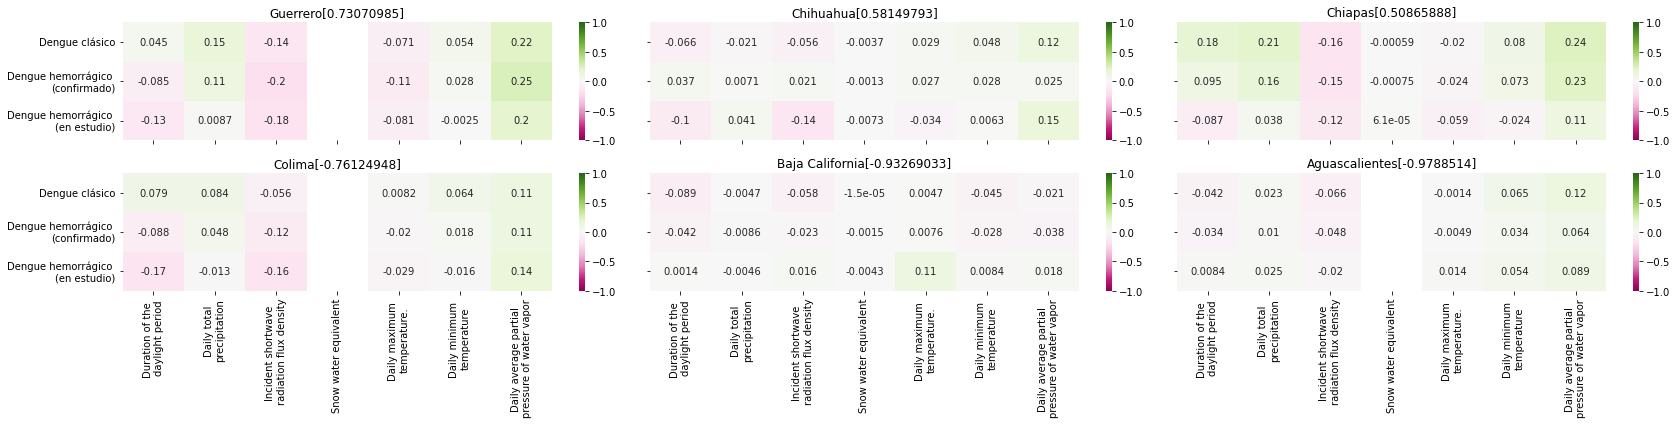

In [16]:
selected = ['Dengue clásico', 'Dengue hemorrágico \n(confirmado)',
       'Dengue hemorrágico \n(en estudio)','dayl', 'prcp',
       'srad', 'swe', 'tmax', 'tmin', 'vp']

rename_ISR_col = {
    "Dengue hemorrágico (confirmado)":"Dengue hemorrágico \n(confirmado)",
    "Dengue hemorrágico (en estudio)":"Dengue hemorrágico \n(en estudio)"}

nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,6), sharey=True, sharex=True)

i = 0
for r in range(nrows):
    for c in range(ncols):
        state = lista_ISR.index[i]
        ISR_value = lista_ISR.values[i]

        df_i = dfISR_worst[dfISR_worst["estado"]==state].copy()

        df_i.rename(columns=rename_ISR_col, inplace=True)

        df_i = df_i[selected].corr().iloc[:3,3:]
        df_i.rename(columns=dict_daymetcols, inplace=True)
        sns.heatmap(df_i, ax=ax[r,c],annot=True, center=0, vmax=1, vmin=-1, cmap="PiYG")

        ax[r,c].set(
            title = state + str(ISR_value)
        )

        i += 1

plt.tight_layout()
#plt.savefig("heatmapcorr.png", dpi=300)
plt.show()

In [39]:
dfISR_worst.head(1)

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT
0,Aguascalientes,2002-01-06,0,0,0,2002,1,38490.104891,0.0,412.658447,0.0,21.732162,1.271458,447.737208,1.0


In [21]:
dfISR_worst[dfISR_worst["year"]==2003]

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp
2080,Aguascalientes,2003-01-05,0,0,0,2003,1,38426.765625,0.0,406.604718,0.0,21.103373,1.931313,263.522093
2081,Aguascalientes,2003-01-05,0,0,0,2003,1,38440.570312,0.0,410.873684,0.0,21.707946,2.137333,280.244726
2082,Aguascalientes,2003-01-05,0,0,0,2003,1,38426.765625,0.0,413.819044,0.0,22.438574,3.214020,319.190966
2083,Aguascalientes,2003-01-05,0,0,0,2003,1,38412.918191,0.0,401.759137,0.0,20.940695,2.374415,256.257935
2084,Aguascalientes,2003-01-05,0,0,0,2003,1,38410.083513,0.0,400.170992,0.0,20.559464,1.918220,247.199837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726923,Guerrero,2003-12-28,0,0,0,2003,52,39650.824219,0.0,348.262714,0.0,32.121705,19.655420,2287.774469
726924,Guerrero,2003-12-28,0,0,0,2003,52,39506.765625,0.0,395.078033,0.0,23.999445,13.679647,1567.667129
726925,Guerrero,2003-12-28,0,0,0,2003,52,39454.109375,0.0,413.116527,0.0,25.847599,11.738238,1326.148927
726926,Guerrero,2003-12-28,0,0,0,2003,52,39637.769531,0.0,345.773894,0.0,31.890414,19.730459,2298.371393


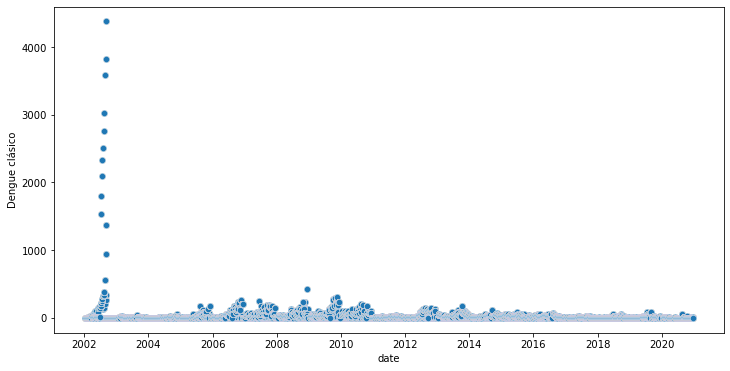

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x="date", y="Dengue clásico", data=dfISR_worst, alpha=0.3)
plt.show()

# Extraer estados con más casos

In [38]:
df.groupby("estado").agg({
    "Dengue clásico":"sum",
    "Dengue hemorrágico (confirmado)":"sum",
    "Dengue hemorrágico (en estudio)":"sum"
})

,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio)
estado,,,
Aguascalientes,50,2,7
Baja California,295,1,122
Baja California Sur,11758,725,4255
Campeche,8286,1038,8258
Chiapas,19306,9893,49347
Chihuahua,67,129,59
Colima,42393,3300,52499
Durango,2427,25,155
Guanajuato,5222,20,430
